# HFF Water Quality

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [152]:
ipe_df = pd.read_csv('data/15_min_data_HFF/IPE 15 min 2022-08-08.csv')
ipe_df

,contTime,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
0,2014-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-06-20 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-06-20 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-06-20 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-06-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285217,2022-08-07 23:00:00,5.48,NaN,NaN,0.34,NaN,0.02,NaN,7.49,NaN,...,18.66,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285218,2022-08-07 23:15:00,5.74,NaN,NaN,0.27,NaN,0.03,NaN,7.48,NaN,...,18.64,123.5,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285219,2022-08-07 23:30:00,6.37,NaN,NaN,0.29,NaN,0.03,NaN,7.47,NaN,...,18.64,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285220,2022-08-07 23:45:00,6.40,NaN,NaN,0.34,NaN,0.02,NaN,7.48,NaN,...,18.63,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
# check first day to make sure averages make sense later
ipe_df.loc[(ipe_df['contTime']<='2014-06-20 24:00:00')]

,contTime,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
0,2014-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-06-20 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-06-20 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-06-20 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-06-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2014-06-20 22:45:00,2.34,NaN,NaN,0.37,NaN,-0.05,NaN,6.10,NaN,...,12.507,97.5,83.0,11.655,NaN,NaN,NaN,NaN,NaN,NaN
92,2014-06-20 23:00:00,2.24,NaN,NaN,0.35,NaN,0.04,NaN,6.05,NaN,...,12.442,97.3,83.0,11.657,NaN,NaN,NaN,NaN,NaN,NaN
93,2014-06-20 23:15:00,2.52,NaN,NaN,0.27,NaN,0.00,NaN,5.94,NaN,...,12.380,97.2,83.0,11.658,NaN,NaN,NaN,NaN,NaN,NaN
94,2014-06-20 23:30:00,2.59,NaN,NaN,0.29,NaN,-0.05,NaN,5.87,NaN,...,12.334,97.0,83.0,11.659,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
ipe_df['contTime'] = pd.to_datetime(ipe_df['contTime'])
ipe_df.set_index(['contTime'], inplace=True)
ipe_df

,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,Temp_C,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
contTime,,,,,,,,,,,,,,,,,,,,,
2014-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-20 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-20 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-20 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-07 23:00:00,5.48,NaN,NaN,0.34,NaN,0.02,NaN,7.49,NaN,18.66,...,18.66,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-07 23:15:00,5.74,NaN,NaN,0.27,NaN,0.03,NaN,7.48,NaN,18.64,...,18.64,123.5,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-07 23:30:00,6.37,NaN,NaN,0.29,NaN,0.03,NaN,7.47,NaN,18.64,...,18.64,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
ipe_daily = ipe_df.resample('D').mean()
ipe_daily

,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,Temp_C,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
contTime,,,,,,,,,,,,,,,,,,,,,
2014-06-20,2.282571,NaN,2.883333,0.343889,NaN,-0.009167,NaN,6.402500,NaN,13.020333,...,13.020333,98.772222,83.000000,11.642306,2.948023,0.603837,0.102474,13.602552,7.434667,119.362484
2014-06-21,2.491979,2.487097,NaN,0.366667,0.367527,-0.003125,-0.002581,6.491563,6.511828,12.617740,...,12.617740,97.936458,83.302083,11.666146,3.087716,0.643661,0.112450,13.759623,7.438532,119.774590
2014-06-22,2.760521,2.760521,NaN,0.370417,0.370417,-0.002396,-0.002396,6.799479,6.799479,12.587917,...,12.587917,98.336458,83.875000,11.690604,3.302915,0.710180,0.154355,13.946474,7.471170,120.355465
2014-06-23,3.366875,3.366875,4.056667,0.427187,0.427187,0.011667,0.011667,6.973333,6.973333,12.869354,...,12.869354,100.618750,85.187500,11.717281,3.678330,0.552335,0.076311,13.898306,7.783264,119.795716
2014-06-24,4.185000,4.185000,NaN,0.578438,0.578438,0.051042,0.051042,6.847812,6.847812,12.998385,...,12.998385,104.945833,88.541667,11.707031,3.881812,0.502070,0.072871,14.001303,7.923084,121.559347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-04,4.318333,4.318333,NaN,0.313750,0.313750,0.028958,0.028958,7.168958,7.168958,19.131562,...,19.131562,155.598958,0.110000,13.178125,3.502886,0.350678,0.072960,18.002343,6.298646,147.223717
2022-08-05,4.368316,4.368316,NaN,0.346526,0.346526,0.035368,0.035368,7.249474,7.249474,19.065474,...,-64.456042,66.297917,-83.214062,-70.295208,3.696916,0.318075,0.048990,17.950932,6.328682,146.903631
2022-08-06,4.182292,4.182292,NaN,0.421458,0.421458,0.057917,0.057917,7.358333,7.358333,19.076875,...,19.076875,140.838542,0.102917,13.171146,3.099911,0.334100,0.052274,17.956837,6.276374,148.263877


<AxesSubplot:xlabel='contTime'>

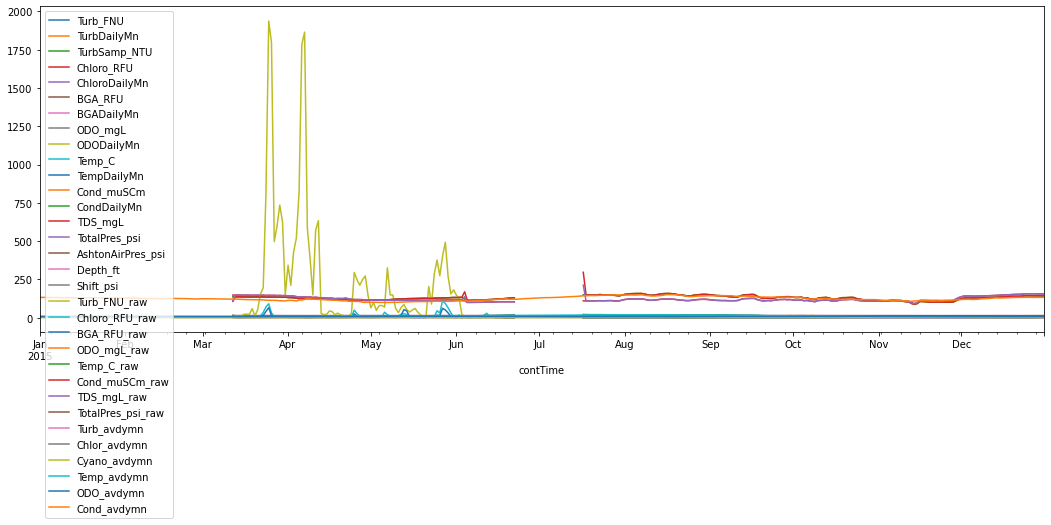

In [156]:
ipe_daily.loc['2015'].plot(figsize=(18,6))

In [157]:
ipe_df.loc['2015-06-01'].isna().sum()

Turb_FNU             96
TurbDailyMn          96
TurbSamp_NTU         96
Chloro_RFU           96
ChloroDailyMn        96
BGA_RFU              96
BGADailyMn           96
ODO_mgL               0
ODODailyMn           95
Temp_C                0
TempDailyMn          95
Cond_muSCm            0
CondDailyMn          95
TDS_mgL               0
TotalPres_psi         0
AshtonAirPres_psi     0
Depth_ft              0
Shift_psi             0
Turb_FNU_raw          0
Chloro_RFU_raw        0
BGA_RFU_raw           0
ODO_mgL_raw           0
Temp_C_raw            0
Cond_muSCm_raw        0
TDS_mgL_raw           0
TotalPres_psi_raw     0
Turb_avdymn          95
Chlor_avdymn         95
Cyano_avdymn         95
Temp_avdymn          95
ODO_avdymn           95
Cond_avdymn          95
dtype: int64

In [158]:
ipe_daily.columns

Index(['Turb_FNU', 'TurbDailyMn', 'TurbSamp_NTU', 'Chloro_RFU',
       'ChloroDailyMn', 'BGA_RFU', 'BGADailyMn', 'ODO_mgL', 'ODODailyMn',
       'Temp_C', 'TempDailyMn', 'Cond_muSCm', 'CondDailyMn', 'TDS_mgL',
       'TotalPres_psi', 'AshtonAirPres_psi', 'Depth_ft', 'Shift_psi',
       'Turb_FNU_raw', 'Chloro_RFU_raw', 'BGA_RFU_raw', 'ODO_mgL_raw',
       'Temp_C_raw', 'Cond_muSCm_raw', 'TDS_mgL_raw', 'TotalPres_psi_raw',
       'Turb_avdymn', 'Chlor_avdymn', 'Cyano_avdymn', 'Temp_avdymn',
       'ODO_avdymn', 'Cond_avdymn'],
      dtype='object')

In [159]:
ipe_daily.drop(['Turb_FNU', 'TurbDailyMn', 'TurbSamp_NTU', 'Chloro_RFU',
       'ChloroDailyMn', 'BGA_RFU', 'BGADailyMn', 'ODO_mgL', 'ODODailyMn',
       'Temp_C', 'TempDailyMn', 'Cond_muSCm', 'CondDailyMn', 'TDS_mgL',
       'Turb_avdymn', 'Chlor_avdymn', 'Cyano_avdymn', 'Temp_avdymn',
       'ODO_avdymn', 'Cond_avdymn'], axis=1, inplace=True)

In [160]:
ipe_daily.columns

Index(['TotalPres_psi', 'AshtonAirPres_psi', 'Depth_ft', 'Shift_psi',
       'Turb_FNU_raw', 'Chloro_RFU_raw', 'BGA_RFU_raw', 'ODO_mgL_raw',
       'Temp_C_raw', 'Cond_muSCm_raw', 'TDS_mgL_raw', 'TotalPres_psi_raw'],
      dtype='object')

C:\Users\harri\AppData\Local\Temp\ipykernel_12456\3173644622.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ipe_daily['2019'].plot(figsize=(16,8))


<AxesSubplot:xlabel='contTime'>

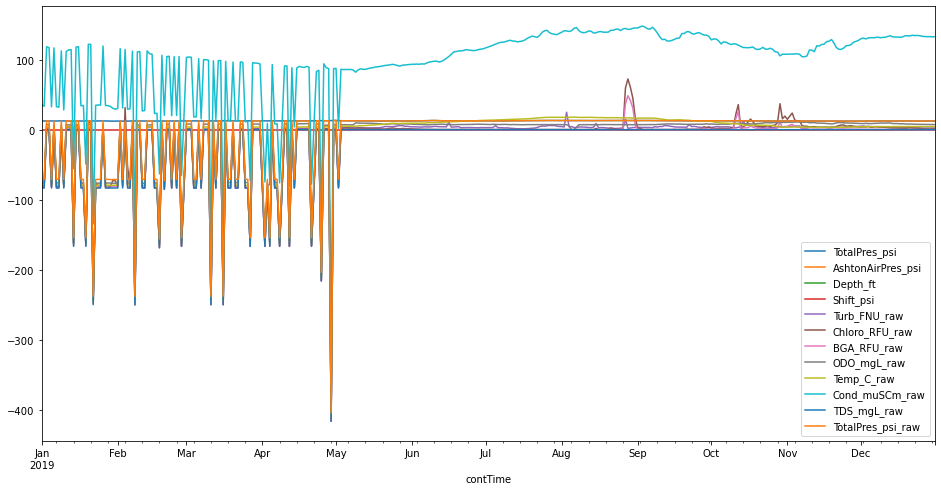

In [183]:
ipe_daily['2019'].plot(figsize=(16,8))

In [162]:
ipe_daily.corr()

,TotalPres_psi,AshtonAirPres_psi,Depth_ft,Shift_psi,Turb_FNU_raw,Chloro_RFU_raw,BGA_RFU_raw,ODO_mgL_raw,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw
TotalPres_psi,1.000000,0.226175,0.951196,0.031913,-0.002242,-0.010508,-0.013720,-0.015427,-0.030335,-0.049109,0.051834,0.998191
AshtonAirPres_psi,0.226175,1.000000,-0.006211,0.030370,-0.030124,0.013604,0.010760,-0.016708,0.086390,0.052521,-0.031161,-0.039587
Depth_ft,0.951196,-0.006211,1.000000,-0.218550,-0.024329,-0.069922,-0.045995,-0.543277,0.751450,0.292242,-0.486399,0.274454
Shift_psi,0.031913,0.030370,-0.218550,1.000000,0.237321,0.121310,0.097678,0.072946,0.049254,0.039010,0.375452,0.030069
Turb_FNU_raw,-0.002242,-0.030124,-0.024329,0.237321,1.000000,0.425527,0.420182,0.415671,0.408504,0.390168,0.344772,0.020132
Chloro_RFU_raw,-0.010508,0.013604,-0.069922,0.121310,0.425527,1.000000,0.988570,0.908167,0.894936,0.815049,0.570414,0.046585
BGA_RFU_raw,-0.013720,0.010760,-0.045995,0.097678,0.420182,0.988570,1.000000,0.934729,0.923514,0.851183,0.590385,0.045251
ODO_mgL_raw,-0.015427,-0.016708,-0.543277,0.072946,0.415671,0.908167,0.934729,1.000000,0.986636,0.908377,0.626604,0.041029
Temp_C_raw,-0.030335,0.086390,0.751450,0.049254,0.408504,0.894936,0.923514,0.986636,1.000000,0.932671,0.613372,0.025658
Cond_muSCm_raw,-0.049109,0.052521,0.292242,0.039010,0.390168,0.815049,0.851183,0.908377,0.932671,1.000000,0.621380,0.002930


In [163]:
hydro_df = pd.read_csv('data/IslandPark.TS.csv')
hydro_df['date'] = pd.to_datetime(hydro_df['date'])
hydro_df.set_index(['date'], inplace=True)
hydro_df.columns

Index(['elevation.ft', 'volume.af', 'smoothed.vol', 'smoothed.elev',
       'surfacearea.acres', 'net.evap.af', 'delta.V.af', 'regQ.cfs',
       'gain.cfs', 'smoothed.natQ.cfs'],
      dtype='object')

In [164]:
# calculate exposed shoreline
hydro_df['exposed_shore'] = 8000 - hydro_df['surfacearea.acres']

In [165]:
hydro_df

,elevation.ft,volume.af,smoothed.vol,smoothed.elev,surfacearea.acres,net.evap.af,delta.V.af,regQ.cfs,gain.cfs,smoothed.natQ.cfs,exposed_shore
date,,,,,,,,,,,
1929-06-01,6242.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,8000.000000
1929-06-02,6242.000000,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,8000.000000
1929-06-03,6242.000000,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,8000.000000
1929-06-04,6242.000000,0.000000,0.000000,6242.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,8000.000000
1929-06-05,6242.000000,0.000000,0.000000,6242.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,8000.000000
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-04,6295.987835,85487.742268,85746.044770,6296.029997,5749.972740,44.999402,-805.902790,922.730000,434.189978,489.088539,2250.027260
2022-08-05,6295.885361,84860.206186,85042.025054,6295.914806,5713.836120,26.240200,-704.019716,883.523125,439.386592,478.063086,2286.163880
2022-08-06,6295.808144,84389.659794,84408.125184,6295.810832,5681.587748,28.283043,-633.899869,893.308542,487.987916,459.484137,2318.412252


<AxesSubplot:xlabel='date'>

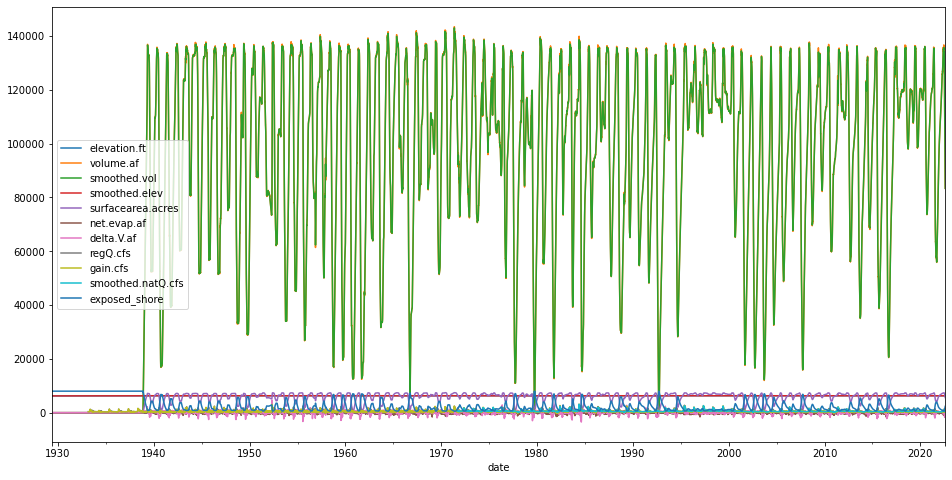

In [166]:
hydro_df.plot(figsize=(16,8))

In [167]:
climate_df = pd.read_csv('data/Clean.Climate.TS.csv')
climate_df['Date'] = pd.to_datetime(climate_df['Date'])
climate_df.set_index(['Date'], inplace=True)
climate_df.drop(['GT.TAVE', 'GT.TMIN', 'GT.TMAX', 'GT.DP', 'GT.AP', 'GT.SWE', 'PB.TAVE',
       'PB.TMIN', 'PB.TMAX', 'PB.DP','HFW.AP', 'TR.SWE', 'FR.SWE', 'HF.SWE', 'HFW.SWE', 'AG.DP', 'AG.ET',
       'HFW.Cum.P', 'AG.Cum.P', 'AG.Cum.ET', 'PB.AP', 'PB.SWE', 'BB.TAVE', 'BB.TMIN', 'BB.TMAX', 'BB.DP', 'BB.AP',
       'BB.SWE', 'LL.TAVE', 'LL.TMIN', 'LL.TMAX', 'LL.DP', 'LL.AP', 'LL.SWE', 'GL.TAVE',
       'GL.TMIN', 'GL.TMAX', 'GL.DP', 'GL.AP', 'GL.SWE', 'PC.TAVE', 'PC.TMIN', 'PC.TMAX',
       'PC.DP', 'PC.AP', 'PC.SWE', 'AL.TAVE', 'AL.TMIN', 'AL.TMAX', 'AL.DP', 'AL.AP',
       'AS.TAVE', 'AS.TMIN', 'AS.TMAX', 'AS.DP', 'AS.AP', 'AS.ET', 'RX.TAVE',
       'RX.TMIN', 'RX.TMAX', 'RX.DP', 'RX.AP', 'RX.ET', 'TR.TAVE', 'FR.TAVE',
       'HF.TAVE', 'VA.TAVE', 'HFW.TAVE', 'TR.TMIN', 'FR.TMIN', 'HF.TMIN',
       'VA.TMIN', 'HFW.TMIN', 'TR.TMAX', 'FR.TMAX', 'HF.TMAX', 'VA.TMAX',
       'HFW.TMAX', 'TR.DP', 'FR.DP', 'HF.DP', 'VA.DP', 'HFW.DP', 'TR.AP',
       'FR.AP', 'HF.AP', 'VA.AP'], axis=1, inplace=True)
climate_df.columns

Index(['WE.TAVE', 'WE.TMIN', 'WE.TMAX', 'WE.DP', 'WE.AP', 'WE.SWE', 'CC.TAVE',
       'CC.TMIN', 'CC.TMAX', 'CC.DP', 'CC.AP', 'CC.SWE', 'IP.TAVE', 'IP.TMIN',
       'IP.TMAX', 'IP.DP', 'IP.AP', 'IP.SWE'],
      dtype='object')

In [168]:
climate_df

,WE.TAVE,WE.TMIN,WE.TMAX,WE.DP,WE.AP,WE.SWE,CC.TAVE,CC.TMIN,CC.TMAX,CC.DP,CC.AP,CC.SWE,IP.TAVE,IP.TMIN,IP.TMAX,IP.DP,IP.AP,IP.SWE
Date,,,,,,,,,,,,,,,,,,
1988-10-01,54.0,44.0,68.0,0.0,0.0,0.0,56.0,46.0,66.0,0.0,0.0,0.0,54.0,35.0,74.0,0.0,0.0,0.0
1988-10-02,55.0,45.0,69.0,0.0,0.0,0.0,57.0,48.0,68.0,0.0,0.0,0.0,53.0,34.0,74.0,0.0,0.0,0.0
1988-10-03,54.0,47.0,70.0,0.0,0.0,0.0,55.0,43.0,69.0,0.0,0.0,0.0,54.0,39.0,74.0,0.0,0.0,0.0
1988-10-04,53.0,41.0,71.0,0.0,0.0,0.0,56.0,44.0,69.0,0.0,0.0,0.0,53.0,35.0,77.0,0.0,0.0,0.0
1988-10-05,53.0,43.0,65.0,0.0,0.0,0.0,55.0,46.0,68.0,0.0,0.0,0.0,51.0,34.0,73.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-04,65.0,56.0,77.0,0.0,39.6,0.2,67.0,56.0,80.0,0.0,22.7,0.0,64.0,44.0,85.0,0.0,24.0,0.0
2022-08-05,56.0,53.0,61.0,0.0,39.6,0.2,58.0,55.0,62.0,0.0,22.7,0.0,57.0,50.0,64.0,0.0,24.0,0.0
2022-08-06,53.0,48.0,57.0,0.0,39.6,0.1,55.0,49.0,63.0,0.0,22.7,0.0,55.0,47.0,63.0,0.0,24.0,0.0


<AxesSubplot:xlabel='Date'>

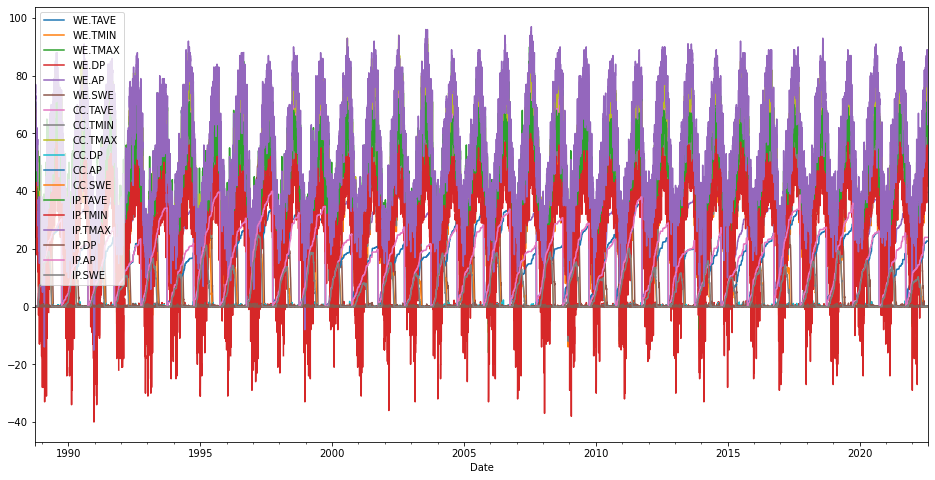

In [169]:
climate_df.plot(figsize=(16,8))

In [170]:
final_df = pd.concat([ipe_daily, climate_df, hydro_df], axis=0)

In [171]:
final_df.isna().sum()

TotalPres_psi        46593
AshtonAirPres_psi    48106
Depth_ft             48151
Shift_psi            46563
Turb_FNU_raw         46593
Chloro_RFU_raw       46593
BGA_RFU_raw          46593
ODO_mgL_raw          46593
Temp_C_raw           46593
Cond_muSCm_raw       46593
TDS_mgL_raw          46593
TotalPres_psi_raw    46593
WE.TAVE              37053
WE.TMIN              37055
WE.TMAX              37053
WE.DP                37009
WE.AP                37009
WE.SWE               37009
CC.TAVE              37106
CC.TMIN              37101
CC.TMAX              37106
CC.DP                37018
CC.AP                37016
CC.SWE               37009
IP.TAVE              37099
IP.TMIN              37115
IP.TMAX              37096
IP.DP                37009
IP.AP                37009
IP.SWE               37009
elevation.ft         15337
volume.af            15337
smoothed.vol         15340
smoothed.elev        15340
surfacearea.acres    15337
net.evap.af          15338
delta.V.af           15341
r

In [176]:
final_df.loc['2015'].isna().sum()

TotalPres_psi        824
AshtonAirPres_psi    800
Depth_ft             824
Shift_psi            824
Turb_FNU_raw         824
Chloro_RFU_raw       824
BGA_RFU_raw          824
ODO_mgL_raw          824
Temp_C_raw           824
Cond_muSCm_raw       824
TDS_mgL_raw          824
TotalPres_psi_raw    824
WE.TAVE              730
WE.TMIN              730
WE.TMAX              730
WE.DP                730
WE.AP                730
WE.SWE               730
CC.TAVE              730
CC.TMIN              730
CC.TMAX              730
CC.DP                739
CC.AP                737
CC.SWE               730
IP.TAVE              730
IP.TMIN              730
IP.TMAX              730
IP.DP                730
IP.AP                730
IP.SWE               730
elevation.ft         730
volume.af            730
smoothed.vol         730
smoothed.elev        730
surfacearea.acres    730
net.evap.af          730
delta.V.af           730
regQ.cfs             730
gain.cfs             730
smoothed.natQ.cfs    730


<AxesSubplot:>

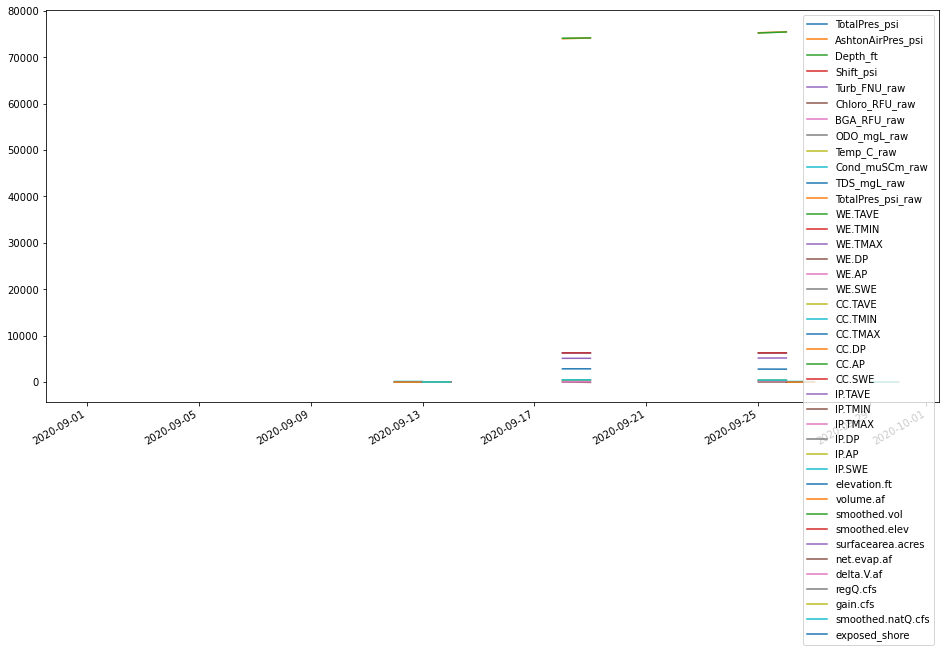

In [187]:
final_df.loc['2020-09'].plot(figsize=(16,8))

In [180]:
final_df.sort_index()

,TotalPres_psi,AshtonAirPres_psi,Depth_ft,Shift_psi,Turb_FNU_raw,Chloro_RFU_raw,BGA_RFU_raw,ODO_mgL_raw,Temp_C_raw,Cond_muSCm_raw,...,volume.af,smoothed.vol,smoothed.elev,surfacearea.acres,net.evap.af,delta.V.af,regQ.cfs,gain.cfs,smoothed.natQ.cfs,exposed_shore
1929-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,8000.000000
1929-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,0.000000,0.00000,NaN,NaN,NaN,NaN,8000.000000
1929-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,0.000000,0.00000,NaN,NaN,NaN,NaN,8000.000000
1929-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,6242.000000,0.000000,0.00000,NaN,NaN,NaN,NaN,8000.000000
1929-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,6242.000000,0.000000,0.00000,0.000000,NaN,NaN,NaN,8000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-07,13.189255,NaN,NaN,0.0,-161.201979,-166.315625,-166.591875,-159.300833,-148.251146,-41.453125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-08,13.170000,NaN,NaN,0.0,5.790000,0.310000,0.040000,7.490000,18.620000,124.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
ipe_chloro = pd.read_csv('data/daily_mean_data_HFF/IPE Chloro Daily Mean IY 2022-08-10.csv')
ipe_chloro

,X,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022,Min,Q1,Median,Mean,Q3,Max,StDev,Year.count
0,01-Nov,NaN,NaN,2.356667,2.386563,4.092838,2.022386,11.270350,1.785934,1.760737,1.785934,2.105956,2.371615,3.985790,3.666269,11.270350,3.660114,6
1,02-Nov,NaN,NaN,2.716092,2.848438,4.503600,2.661129,15.463440,1.851591,1.899451,1.851591,2.674870,2.782265,5.007382,4.089810,15.463440,5.195342,6
2,03-Nov,NaN,NaN,2.686742,3.163229,4.775526,2.610761,20.060360,1.985000,1.861522,1.985000,2.629756,2.924986,5.880270,4.372452,20.060360,7.010552,6
3,04-Nov,NaN,NaN,3.100000,3.595543,4.788987,3.131609,12.520500,2.282283,2.235882,2.282283,3.107902,3.363576,4.903154,4.490626,12.520500,3.821140,6
4,05-Nov,NaN,NaN,3.733000,3.743830,4.809079,4.087778,9.139118,2.434176,2.282674,2.434176,3.735708,3.915804,4.657830,4.628754,9.139118,2.326591,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27-Oct,NaN,1.601702,1.971489,2.826914,0.867727,5.679706,1.339186,1.126630,NaN,0.867727,1.232908,1.601702,2.201908,2.399202,5.679706,1.662308,7
361,28-Oct,NaN,1.832022,2.439167,2.858171,0.986563,7.848113,1.724110,1.228587,NaN,0.986563,1.476348,1.832022,2.702390,2.648669,7.848113,2.359476,7
362,29-Oct,NaN,2.125506,2.274271,2.307416,1.058495,9.245000,2.066757,1.150737,NaN,1.058495,1.608747,2.125506,2.889740,2.290843,9.245000,2.850327,7
363,30-Oct,NaN,2.350000,2.246979,3.435679,1.266354,9.547105,1.397561,1.263936,NaN,1.263936,1.331957,2.246979,3.072516,2.892840,9.547105,2.960698,7


<AxesSubplot:>

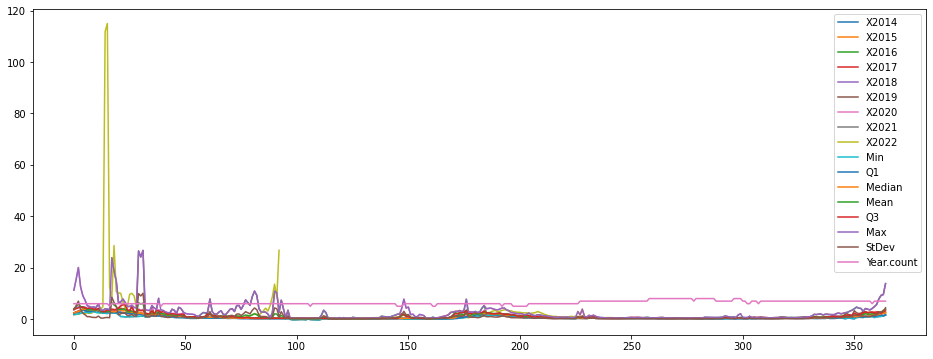

In [207]:
ipe_chloro.plot(figsize=(16,6))

In [203]:
ipe_cond = pd.read_csv('data/daily_mean_data_HFF/IPE Cond Daily Mean IY 2022-08-10.csv')
ipe_cond

,X,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022,Min,Q1,Median,Mean,Q3,Max,StDev,Year.count
0,01-Nov,NaN,95.90947,110.4885,128.5469,110.1702,133.9132,107.8240,120.752600,117.303125,95.90947,108.997100,110.488500,115.372124,124.649750,133.9132,13.121068,7
1,02-Nov,NaN,95.06737,109.6737,126.9781,109.6937,129.6117,107.8737,120.002100,117.422105,95.06737,108.773700,109.693700,114.128624,123.490100,129.6117,12.119563,7
2,03-Nov,NaN,97.82917,108.3333,122.6167,109.4708,122.9365,108.0589,119.557300,116.756250,97.82917,108.196100,109.470800,112.686096,121.087000,122.9365,9.330285,7
3,04-Nov,NaN,100.18330,110.2240,119.1875,108.8031,120.3387,108.2937,119.392700,116.540860,100.18330,108.548400,110.224000,112.346143,119.290100,120.3387,7.547105,7
4,05-Nov,NaN,100.40830,111.3865,117.7531,107.9042,118.1874,108.3240,119.178100,117.761538,100.40830,108.114100,111.386500,111.877371,117.970250,119.1781,6.926211,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27-Oct,104.8042,114.29580,124.3208,112.6427,137.2474,111.4885,122.1379,116.155914,NaN,104.80420,112.354150,115.225857,117.886652,122.683625,137.2474,9.926771,8
361,28-Oct,104.7094,114.08750,125.9542,113.4562,136.3500,110.8604,121.6183,117.332258,NaN,104.70940,112.807250,115.709879,118.046032,122.702275,136.3500,9.834927,8
362,29-Oct,103.9750,113.71350,126.0333,113.4552,136.3094,105.5104,121.2684,118.594737,NaN,103.97500,111.469000,116.154118,117.357492,122.459625,136.3094,10.685248,8
363,30-Oct,103.1365,112.48020,129.7688,110.9073,135.4663,107.9074,121.2510,118.774737,NaN,103.13650,110.157325,115.627468,117.461530,123.380450,135.4663,11.058188,8


<AxesSubplot:>

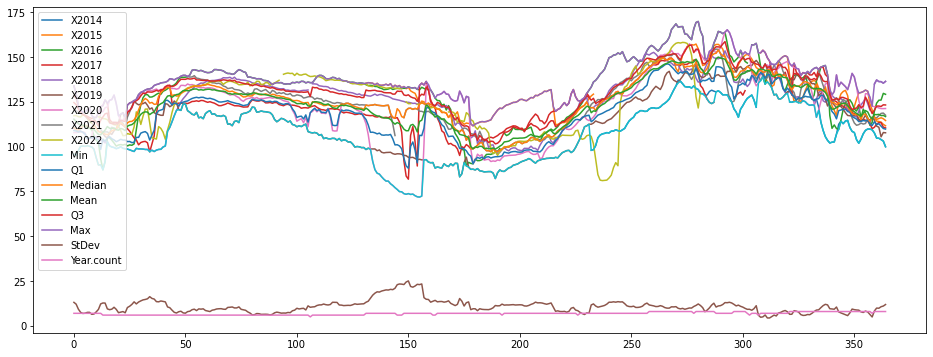

In [208]:
ipe_cond.plot(figsize=(16,6))

In [202]:
ipe_odo = pd.read_csv('data/daily_mean_data_HFF/IPE ODO Daily Mean IY 2022-08-10.csv')
ipe_odo

,X,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022,Min,Q1,Median,Mean,Q3,Max,StDev,Year.count
0,01-Nov,NaN,8.533789,10.006670,7.606146,9.435532,9.242418,10.664170,9.005684,9.139167,7.606146,8.769737,9.242418,9.213487,9.721101,10.66417,0.989316,7
1,02-Nov,NaN,8.870526,10.022530,7.763542,9.339063,9.301915,10.824530,9.085000,9.111158,7.763542,8.977763,9.301915,9.315301,9.680796,10.82453,0.951972,7
2,03-Nov,NaN,8.718958,10.048440,7.929167,9.308750,9.707083,10.878000,9.173646,9.124792,7.929167,8.946302,9.308750,9.394863,9.877762,10.87800,0.947436,7
3,04-Nov,NaN,8.891979,10.180730,8.027917,9.355208,9.788817,10.906740,9.261250,9.228280,8.027917,9.076614,9.355208,9.487520,9.984773,10.90674,0.925502,7
4,05-Nov,NaN,9.340729,10.301150,8.055729,9.469583,9.403684,11.079380,9.343854,9.212088,8.055729,9.342291,9.403684,9.570587,9.885366,11.07938,0.935171,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27-Oct,8.004792,9.839688,7.745417,8.990312,9.270737,10.344480,8.546316,8.800753,NaN,7.745417,8.410935,8.895532,8.942812,9.412975,10.34448,0.875857,8
361,28-Oct,8.304375,9.904271,7.493542,8.534583,9.370521,10.171460,8.556774,8.972258,NaN,7.493542,8.477031,8.764516,8.913473,9.503958,10.17146,0.881116,8
362,29-Oct,8.436042,9.816458,7.601354,8.368542,9.258333,10.456670,8.617263,8.956000,NaN,7.601354,8.419167,8.786632,8.938833,9.397864,10.45667,0.898150,8
363,30-Oct,8.602917,9.697292,7.567083,9.724271,9.355579,10.452740,8.782708,8.960632,NaN,7.567083,8.737760,9.158105,9.142903,9.704037,10.45274,0.873744,8


<AxesSubplot:>

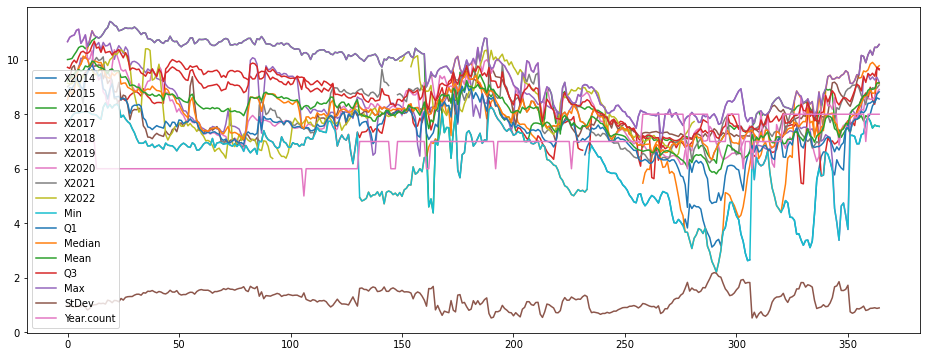

In [209]:
ipe_odo.plot(figsize=(16,6))

In [201]:
ipe_turbid = pd.read_csv("data/daily_mean_data_HFF/IPE Turbidity Daily Mean IY 2022-08-10.csv")
ipe_turbid

,X,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022,Min,Q1,Median,Mean,Q3,Max,StDev,Year.count
0,01-Nov,NaN,NaN,3.208105,2.949688,2.876667,3.249149,4.347083,3.024211,5.588842,2.876667,2.968319,3.116158,3.275817,3.238888,4.347083,0.544407,6
1,02-Nov,NaN,NaN,3.243263,2.991250,2.873750,2.263295,4.526947,2.809792,5.366809,2.263295,2.825782,2.932500,3.118050,3.180260,4.526947,0.761848,6
2,03-Nov,NaN,NaN,3.025521,2.599579,2.746146,0.830968,5.030737,2.810426,6.291458,0.830968,2.636221,2.778286,2.840563,2.971747,5.030737,1.336970,6
3,04-Nov,NaN,NaN,2.917579,2.313958,2.837188,1.320581,5.095368,2.880105,6.521522,1.320581,2.444765,2.858646,2.894130,2.908211,5.095368,1.237909,6
4,05-Nov,NaN,NaN,2.910833,2.347604,2.915417,0.617826,5.108229,2.921875,6.538022,0.617826,2.488411,2.913125,2.803631,2.920260,5.108229,1.437696,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27-Oct,NaN,3.373333,3.925319,2.432211,5.790526,3.073125,3.604526,6.443441,NaN,2.432211,3.223229,3.604526,4.091783,4.857922,6.443441,1.471347,7
361,28-Oct,NaN,3.300729,3.820833,2.681702,4.629579,3.516354,3.448280,5.313763,NaN,2.681702,3.374505,3.516354,3.815891,4.225206,5.313763,0.883400,7
362,29-Oct,NaN,3.469158,3.605000,2.871875,4.562660,4.033085,3.291809,5.361170,NaN,2.871875,3.380483,3.605000,3.884965,4.297873,5.361170,0.845562,7
363,30-Oct,NaN,3.355833,3.640632,2.921771,3.964688,4.068947,3.231828,6.720105,NaN,2.921771,3.293830,3.640632,3.986258,4.016818,6.720105,1.271509,7


In [200]:
ipe_temp = pd.read_csv("data/daily_mean_data_HFF/IPE Temp_C Daily Mean IY 2022-08-10.csv")
ipe_temp

,X,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022,Min,Q1,Median,Mean,Q3,Max,StDev,Year.count
0,01-Nov,NaN,7.453442,7.898646,7.429729,5.933255,6.539264,3.773323,5.605284,7.106448,3.773323,5.769270,6.539264,6.376135,7.441586,7.898646,1.424797,7
1,02-Nov,NaN,7.646242,7.547926,7.450990,5.761427,6.645404,3.823053,5.524563,7.179147,3.823053,5.642995,6.645404,6.342801,7.499458,7.646242,1.404017,7
2,03-Nov,NaN,7.326146,7.116865,7.362844,5.679490,6.617687,3.900253,5.504823,7.100490,3.900253,5.592156,6.617687,6.215444,7.221506,7.362844,1.269966,7
3,04-Nov,NaN,7.345667,7.222812,7.249729,5.509135,6.382957,3.933084,5.439021,7.061763,3.933084,5.474078,6.382957,6.154629,7.236270,7.345667,1.269841,7
4,05-Nov,NaN,7.281333,7.183896,7.125896,5.266781,6.215853,3.982396,5.378979,6.987198,3.982396,5.322880,6.215853,6.062162,7.154896,7.281333,1.246636,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27-Oct,8.886104,9.060667,7.440260,6.615135,6.403621,5.015500,6.117116,7.803828,NaN,5.015500,6.331995,7.027698,7.167779,8.074397,9.060667,1.395913,8
361,28-Oct,8.667104,9.020854,7.432146,6.567833,6.487563,4.858271,5.951226,7.764376,NaN,4.858271,6.353479,6.999989,7.093672,7.990058,9.020854,1.398990,8
362,29-Oct,8.511771,8.923000,7.408333,6.472104,6.431740,3.641906,5.851695,7.698021,NaN,3.641906,6.286729,6.940219,6.867321,7.901459,8.923000,1.677307,8
363,30-Oct,8.279510,8.638146,7.488521,6.123677,6.473737,3.819000,5.800750,7.637874,NaN,3.819000,6.042945,6.981129,6.782652,7.798283,8.638146,1.567078,8


<AxesSubplot:>

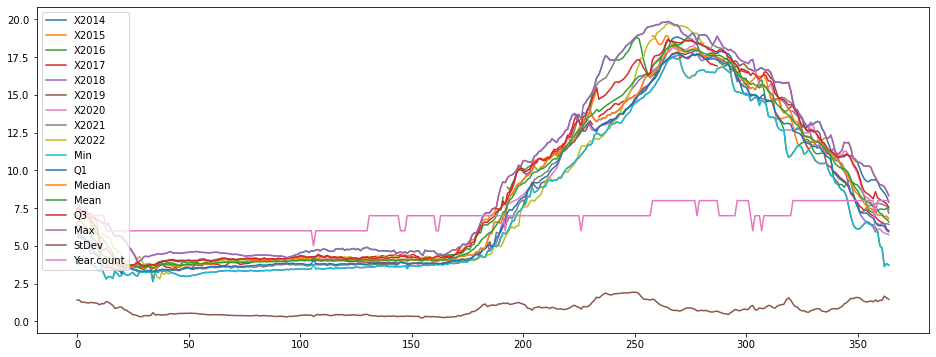

In [210]:
ipe_temp.plot(figsize=(16,6))

In [205]:
ipe_bga = pd.read_csv('data/daily_mean_data_HFF/IPE BGA Daily Mean IY 2022-08-10.csv')
ipe_bga

,X,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022,Min,Q1,Median,Mean,Q3,Max,StDev,Year.count
0,01-Nov,NaN,NaN,0.590938,0.568125,0.830106,0.495000,3.677949,0.188947,0.613021,0.188947,0.513281,0.579531,1.058511,0.770314,3.677949,1.299724,6
1,02-Nov,NaN,NaN,0.572842,0.644687,0.858437,0.860422,5.970725,0.192083,0.649362,0.192083,0.590803,0.751563,1.516533,0.859926,5.970725,2.195825,6
2,03-Nov,NaN,NaN,0.602604,0.735313,0.869687,0.668632,7.273281,0.199792,0.541771,0.199792,0.619111,0.701972,1.724885,0.836094,7.273281,2.727505,6
3,04-Nov,NaN,NaN,0.696354,0.809792,0.934063,0.719032,5.221831,0.225729,0.689677,0.225729,0.702024,0.764412,1.434467,0.902995,5.221831,1.870960,6
4,05-Nov,NaN,NaN,0.849688,0.872812,0.880313,0.975914,3.508235,0.256250,0.699780,0.256250,0.855469,0.876563,1.223869,0.952014,3.508235,1.148684,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27-Oct,NaN,0.305625,0.490417,0.684516,0.239341,1.700208,0.154211,0.489462,NaN,0.154211,0.272483,0.489462,0.580540,0.587466,1.700208,0.525141,7
361,28-Oct,NaN,0.371250,0.536042,0.597979,0.214271,2.296154,0.267753,0.512935,NaN,0.214271,0.319501,0.512935,0.685198,0.567010,2.296154,0.724489,7
362,29-Oct,NaN,0.450208,0.526354,0.548958,0.230860,3.303111,0.285591,0.437263,NaN,0.230860,0.361427,0.450208,0.826050,0.537656,3.303111,1.098574,7
363,30-Oct,NaN,0.525312,0.507083,1.032083,0.277790,3.241071,0.206210,0.434316,NaN,0.206210,0.356053,0.507083,0.889124,0.778698,3.241071,1.070620,7


<AxesSubplot:>

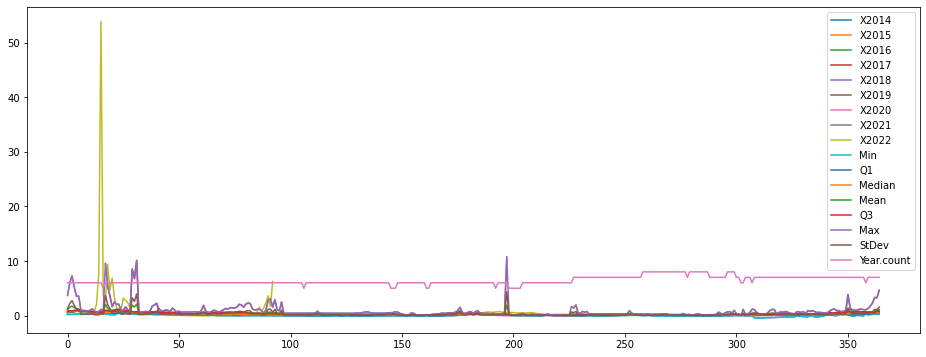

In [211]:
ipe_bga.plot(figsize=(16,6))